# 02 - Cell Type Annotation

This notebook demonstrates clustering and cell type annotation for single-cell data.

## Overview

Steps include:
1. Load preprocessed data
2. Neighbor graph construction
3. Clustering (Leiden algorithm)
4. UMAP visualization
5. Marker gene identification
6. Cell type annotation

## Setup

In [69]:
import os
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

##################################################
suffix = '22.01.26' # change to date of analysis #
##################################################

# Set working directory to notebook location
notebook_dir = r'z:\thornes\Pavlicev_lab_rotation\FLUXestimator\notebooks'
os.chdir(notebook_dir)
print(f"Working directory: {os.getcwd()}")

# Configure scanpy
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor='white', figsize=(10, 10))

print(f"Scanpy version: {sc.__version__}")

sc_output_dir = rf'z:\thornes\Pavlicev_lab_rotation\FLUXestimator\results\single_cell_annotations\{suffix}'
if not os.path.exists(sc_output_dir):
    os.makedirs(sc_output_dir)


Working directory: z:\thornes\Pavlicev_lab_rotation\FLUXestimator\notebooks
Scanpy version: 1.11.5


C:\Users\dell\AppData\Local\Temp\ipykernel_40132\47688962.py:22: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('scanpy')` instead
  print(f"Scanpy version: {sc.__version__}")


## Load Configuration and Data

In [70]:
# Load configuration
with open('../config/analysis_config.yaml', 'r') as f:
    config = yaml.safe_load(f)

In [71]:
# Load preprocessed data
adata = sc.read_h5ad(f'../data/processed/{suffix}/preprocessed_data.h5ad')

print(f"Loaded data: {adata.shape[0]} cells x {adata.shape[1]} genes")
adata

# Get normalized log-transformed expression as DataFrame
expr_df = pd.DataFrame(
    adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X,
    index=adata.obs_names,  # Cell barcodes as rows
    columns=adata.var_names  # Gene names as columns
)

# Display first few rows and columns
print(f"Expression matrix shape: {expr_df.shape}")
print(f"Cells: {expr_df.shape[0]}, Genes: {expr_df.shape[1]}")

#trasnpose matrix to have gees as rows and cells as columns
expr_df_transposed = expr_df.T

# Save to CSV
expr_df_transposed.to_csv(f'../data/processed/{suffix}/expression_matrix.csv')
print(f"Expression matrix saved to '../data/processed/{suffix}/expression_matrix.csv'")
expr_df_transposed.iloc[:5, :5]  # Display first 5 genes and 5 cells


Loaded data: 7964 cells x 23554 genes
Expression matrix shape: (7964, 23554)
Cells: 7964, Genes: 23554
Expression matrix saved to '../data/processed/22.01.26/expression_matrix.csv'


AAACCCAAGGGTGAAA-1  AAACCCAAGTTTCAGC-1  AAACCCACAAACTAAG-1  \
Xkr4               0.143802           -0.458689           -0.458689   
Gm1992            -0.098636           -0.098636           -0.098636   
Gm19938            3.139906           -0.172230           -0.172230   
Gm37381           -0.024778           -0.024778           -0.024778   
Rp1               -0.045856           -0.045856           -0.045856   

         AAACCCACAGAAACCG-1  AAACCCACAGGTTTAC-1  
Xkr4               0.820926           -0.458689  
Gm1992            -0.098636           -0.098636  
Gm19938           -0.172230           -0.172230  
Gm37381           -0.024778           -0.024778  
Rp1               -0.045856           -0.045856

## Neighborhood Graph

Construct k-nearest neighbor graph in PCA space.

In [72]:
# Compute neighborhood graph
sc.pp.neighbors(
    adata,
    n_neighbors=config['cell_annotation']['n_neighbors'],
    n_pcs=config['cell_annotation']['n_pcs']
)

print("Neighborhood graph computed")

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
Neighborhood graph computed


## Clustering

Apply Leiden clustering algorithm.

In [73]:
# Leiden clustering
sc.tl.leiden(
    adata,
    # resolution=config['cell_annotation']['resolution'],
    resolution=0.8,
    random_state=config['compute']['random_state']
)

print(f"Identified {adata.obs['leiden'].nunique()} clusters")
print(adata.obs['leiden'].value_counts().sort_index())

# for res in [0.4, 0.6, 0.8, 1.0, 1.2]:
#     sc.tl.leiden(adata, resolution=res, key_added=f'leiden_{res}')
#     print(f"Resolution {res}: {adata.obs[f'leiden_{res}'].nunique()} clusters")

running Leiden clustering
    finished: found 20 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
Identified 20 clusters
leiden
0     1644
1      965
2      826
3      743
4      743
5      460
6      420
7      371
8      363
9      328
10     315
11     229
12     205
13     109
14      62
15      49
16      44
17      40
18      33
19      15
Name: count, dtype: int64


## UMAP Visualization

Compute UMAP embedding for visualization.

In [74]:
# Compute UMAP
sc.tl.umap(
    adata,
    min_dist=config['visualisation']['umap_min_dist'],
    spread=config['visualisation']['umap_spread'],
    random_state=config['compute']['random_state']
)

print("UMAP embedding computed")

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:12)
UMAP embedding computed


UMAP plot saved to z:\thornes\Pavlicev_lab_rotation\FLUXestimator\results\single_cell_annotations\22.01.26\umap_leiden_clusters.png


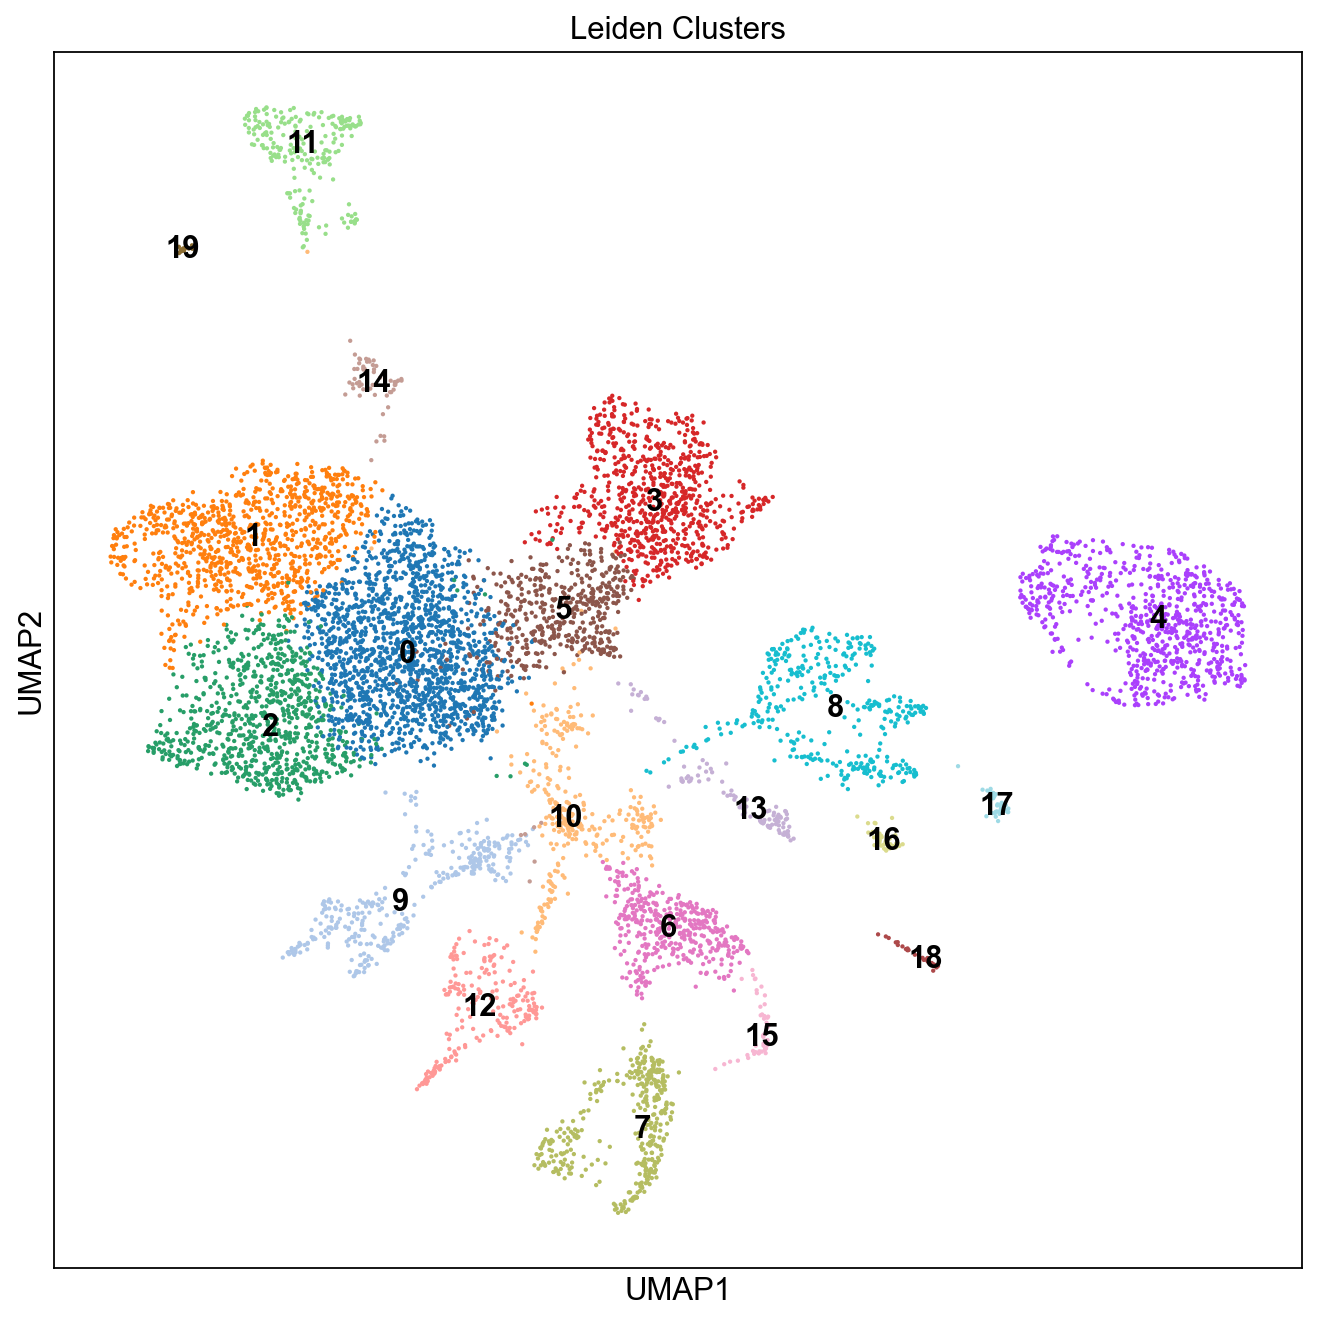

In [75]:
# Visualize clusters
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='Leiden Clusters', show=False)
# save image to output directory
plt.savefig(os.path.join(sc_output_dir, 'umap_leiden_clusters.png'), dpi=150, bbox_inches='tight')
print(f"UMAP plot saved to {os.path.join(sc_output_dir, 'umap_leiden_clusters.png')}")
plt.show()

## Marker Gene Identification

Find differentially expressed genes for each cluster.

In [76]:
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)

# Find marker genes for each cluster
sc.tl.rank_genes_groups(
    adata,
    groupby='leiden',
    method='wilcoxon',
    key_added='rank_genes'
)

print("Marker gene analysis complete")

ranking genes
    finished: added to `.uns['rank_genes']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:34)
Marker gene analysis complete


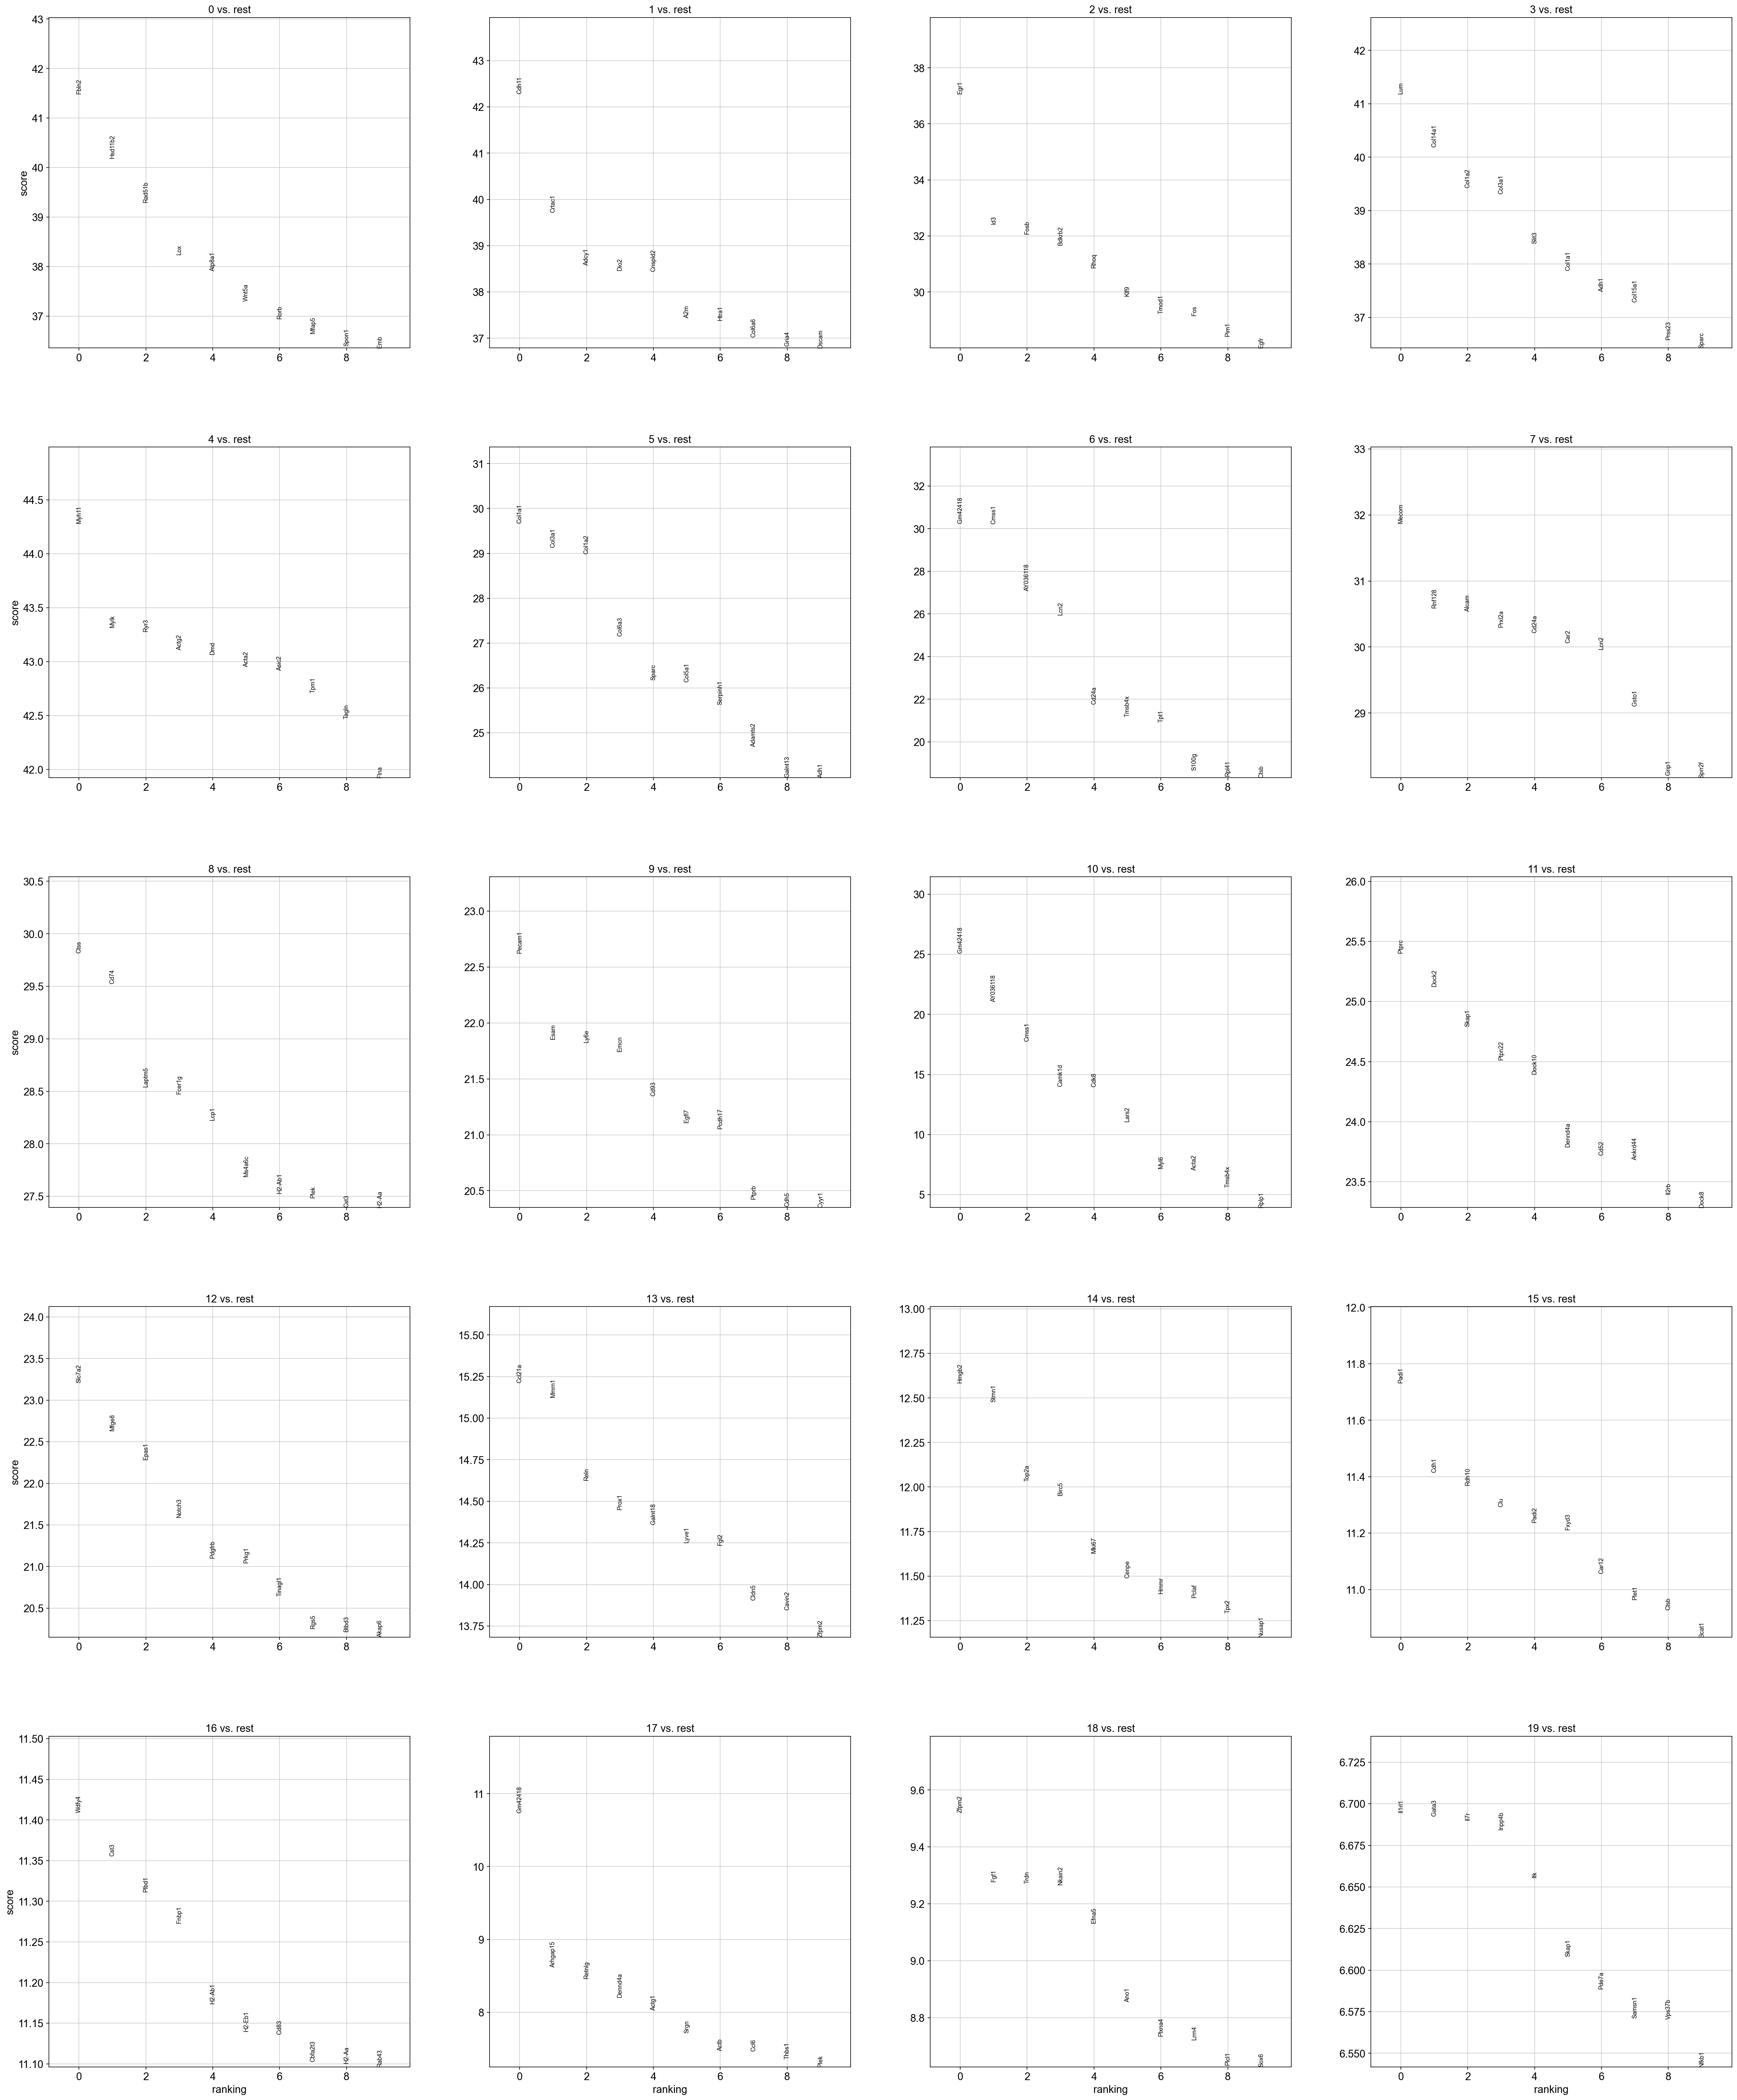

In [77]:
# Visualize top marker genes
sc.pl.rank_genes_groups(adata, n_genes=10, key='rank_genes', sharey=False)

In [78]:
# Get top marker genes as dataframe
marker_df = sc.get.rank_genes_groups_df(adata, group=None, key='rank_genes')
# save matrix
marker_df.to_csv('../results/tables/marker_genes.csv', index=False)
marker_df.head(20)

group     names     scores  logfoldchanges          pvals      pvals_adj
0      0     Fbln2  41.492325             NaN   0.000000e+00   0.000000e+00
1      0   Hsd11b2  40.190632             NaN   0.000000e+00   0.000000e+00
2      0    Rad51b  39.294933             NaN   0.000000e+00   0.000000e+00
3      0       Lox  38.242939             NaN   0.000000e+00   0.000000e+00
4      0    Atp8a1  37.908398             NaN   0.000000e+00   0.000000e+00
5      0     Wnt5a  37.304432             NaN  1.390789e-304  5.459773e-301
6      0      Rorb  36.950451             NaN  7.163473e-299  2.410406e-295
7      0     Mfap5  36.649014             NaN  4.744310e-294  1.396844e-290
8      0     Spon1  36.400436             NaN  4.189626e-290  1.096472e-286
9      0       Emb  36.356449             NaN  2.078118e-289  4.894799e-286
10     0     Anxa3  35.807343             NaN  8.489585e-281  1.817852e-277
11     0      Cd34  35.520672             NaN  2.357916e-276  4.628197e-273
12     0  Adamts12  35.279335             NaN  1.218315e-272  2.207400e-269
13     0     Sned1  35.258759             NaN  2.519003e-272  4.238043e-269
14     0      Fbn1  34.720829             NaN  3.820957e-264  5.999922e-261
15     0     Acss3  34.690868             NaN  1.081725e-263  1.592435e-260
16     0     Radil  34.275455             NaN  1.821932e-257  2.524341e-254
17     0     Ramp2  34.029827             NaN  8.069799e-254  1.055978e-250
18     0    Sncaip  33.790524             NaN  2.717484e-250  3.368822e-247
19     0    Atp8b1  33.610752             NaN  1.168434e-247  1.376065e-244

## Cell Type Annotation

Annotate clusters based on known marker genes.

Dotplot saved to z:\thornes\Pavlicev_lab_rotation\FLUXestimator\results\single_cell_annotations\22.01.26\dotplot_marker_genes.png


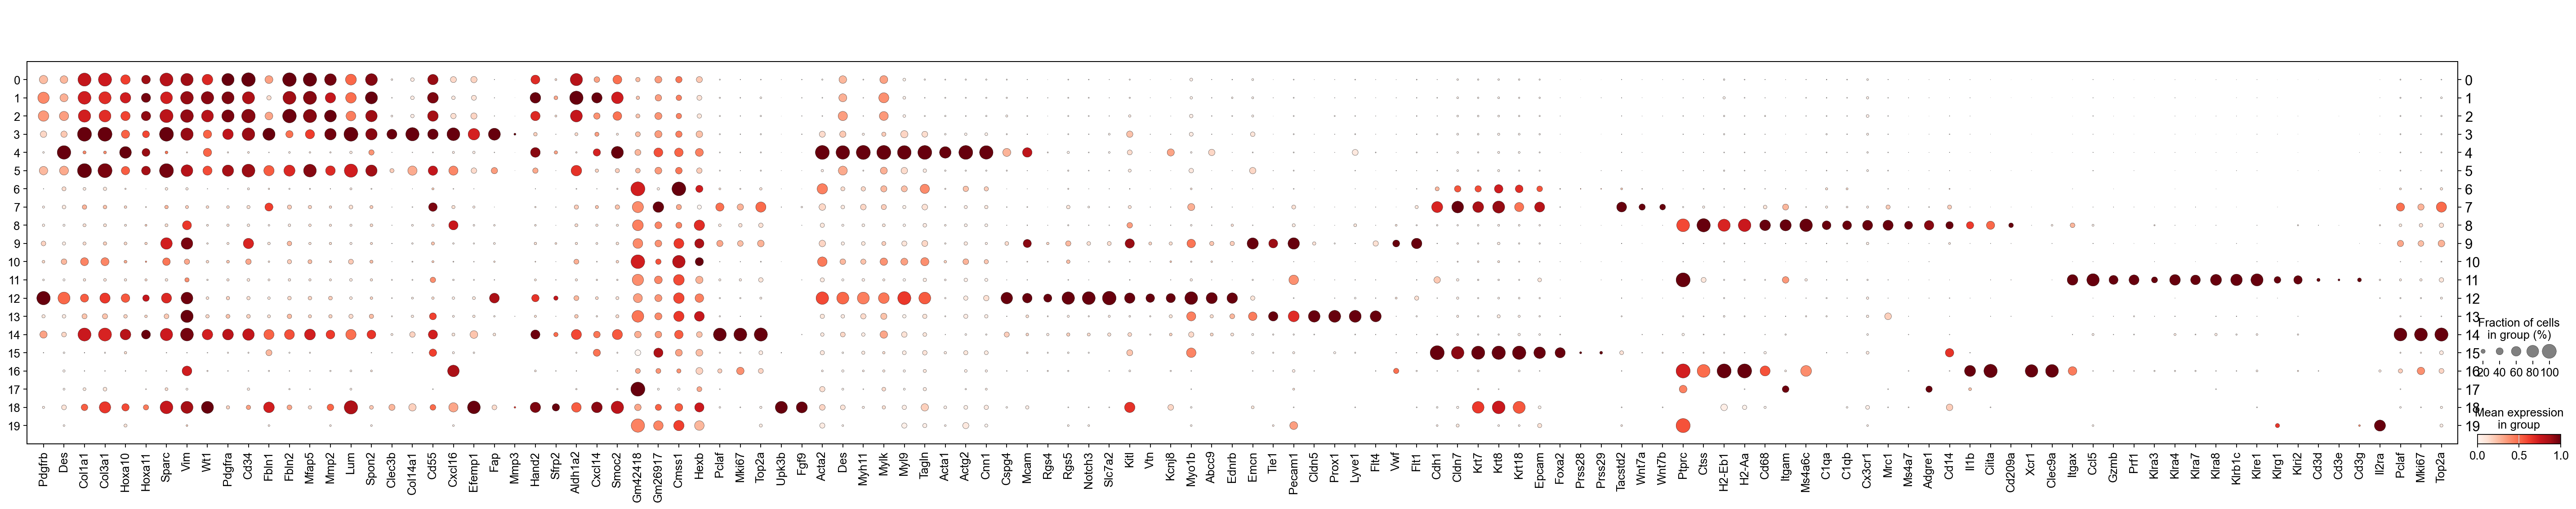

In [91]:
# Define marker genes for reproductive tissue cell types
marker_genes = config['cell_annotation']['marker_genes']

# Visualize marker gene expression
all_markers = [gene for genes in marker_genes.values() for gene in genes]
available_markers = [g for g in all_markers if g in adata.var_names]

if len(available_markers) > 0:
    sc.pl.dotplot(
        adata,
        var_names=available_markers[:150],  # Show first 150 available markers
        groupby='leiden',
        standard_scale='var',
        show=False
    )
    
    # Add cluster labels on the right side for easier cross-referencing
    fig = plt.gcf()
    axes = fig.get_axes()
    # The main dotplot axis is typically the largest one with ytick labels
    main_ax = None
    for ax in axes:
        if len(ax.get_yticklabels()) > 0:
            main_ax = ax
            break
    
    if main_ax is not None:
        ax2 = main_ax.twinx()
        ax2.set_ylim(main_ax.get_ylim())
        ax2.set_yticks(main_ax.get_yticks())
        ax2.set_yticklabels([label.get_text() for label in main_ax.get_yticklabels()])
        ax2.grid(False)  # Disable grid lines on the right axis
        ax2.set_ylabel('')  # No label needed
    
    # Adjust legend position to avoid overlap with right labels
    for ax in axes:
        legend = ax.get_legend()
        if legend is not None:
            # Move legend to the right, keeping it at the bottom
            legend.set_bbox_to_anchor((1.5, 0.0))
            legend.set_loc('lower left')
    
    # save image to output directory
    plt.savefig(os.path.join(sc_output_dir, 'dotplot_marker_genes.png'), dpi=150, bbox_inches='tight')
    print(f"Dotplot saved to {os.path.join(sc_output_dir, 'dotplot_marker_genes.png')}")
    plt.show()
else:
    print("Note: Marker genes not found in dataset.")

In [92]:
# Manual annotation based on marker gene expression

cluster_annotations = {
    '0': 'Fibroblast Cells',
    '1': 'Fibroblast Cells',
    '2': 'Inner Fibroblast Cells',
    '3': 'Fibroblasts: Clec3b+ (outer/basal)',
    '4': 'Myometrium',
    '5': 'Fibroblast Cells',
    '6': 'Epithelial Cells',
    '7': 'Luminal Epithelial Cells',
    '8': 'Macrophage Cells',
    '9': 'Vascular Endothelial Cells',
    '10': 'Ignore',
    '11': 'Natural Killer Cells',
    '12': 'Perivascular/Mural Cells',
    '13': 'Lymphatic Endothelial Cells',
    '14': 'Proliferating Fibroblast Cells',
    '15': 'Glandular Epithelial Cells',
    '16': 'Dendritic Monocyte Cells',
    '17': 'Inconclusive',
    '18': 'Mesothelial Cells',
    '19': 'T Cells'
}

# Map cluster IDs to cell type names
adata.obs['cell_type'] = adata.obs['leiden'].map(cluster_annotations)

# For unmapped clusters, keep cluster ID
adata.obs['cell_type'] = adata.obs['cell_type'].fillna('Cluster ' + adata.obs['leiden'].astype(str))

print("Cell type annotations:")
print(adata.obs['cell_type'].value_counts())
# save annotated data
adata.obs.to_csv(os.path.join(sc_output_dir, 'annotated_data.csv'))
print(f"Annotated data saved to {os.path.join(sc_output_dir, 'annotated_data.csv')}")

Cell type annotations:
cell_type
Fibroblast Cells                      3069
Inner Fibroblast Cells                 826
Fibroblasts: Clec3b+ (outer/basal)     743
Myometrium                             743
Epithelial Cells                       420
Luminal Epithelial Cells               371
Macrophage Cells                       363
Vascular Endothelial Cells             328
Ignore                                 315
Natural Killer Cells                   229
Perivascular/Mural Cells               205
Lymphatic Endothelial Cells            109
Proliferating Fibroblast Cells          62
Glandular Epithelial Cells              49
Dendritic Monocyte Cells                44
Inconclusive                            40
Mesothelial Cells                       33
T Cells                                 15
Name: count, dtype: int64
Annotated data saved to z:\thornes\Pavlicev_lab_rotation\FLUXestimator\results\single_cell_annotations\22.01.26\annotated_data.csv


Plotting 7609 cells (excluded 355 unassigned cells)
UMAP plot saved to z:\thornes\Pavlicev_lab_rotation\FLUXestimator\results\single_cell_annotations\22.01.26\umap_cell_type_annotations.png


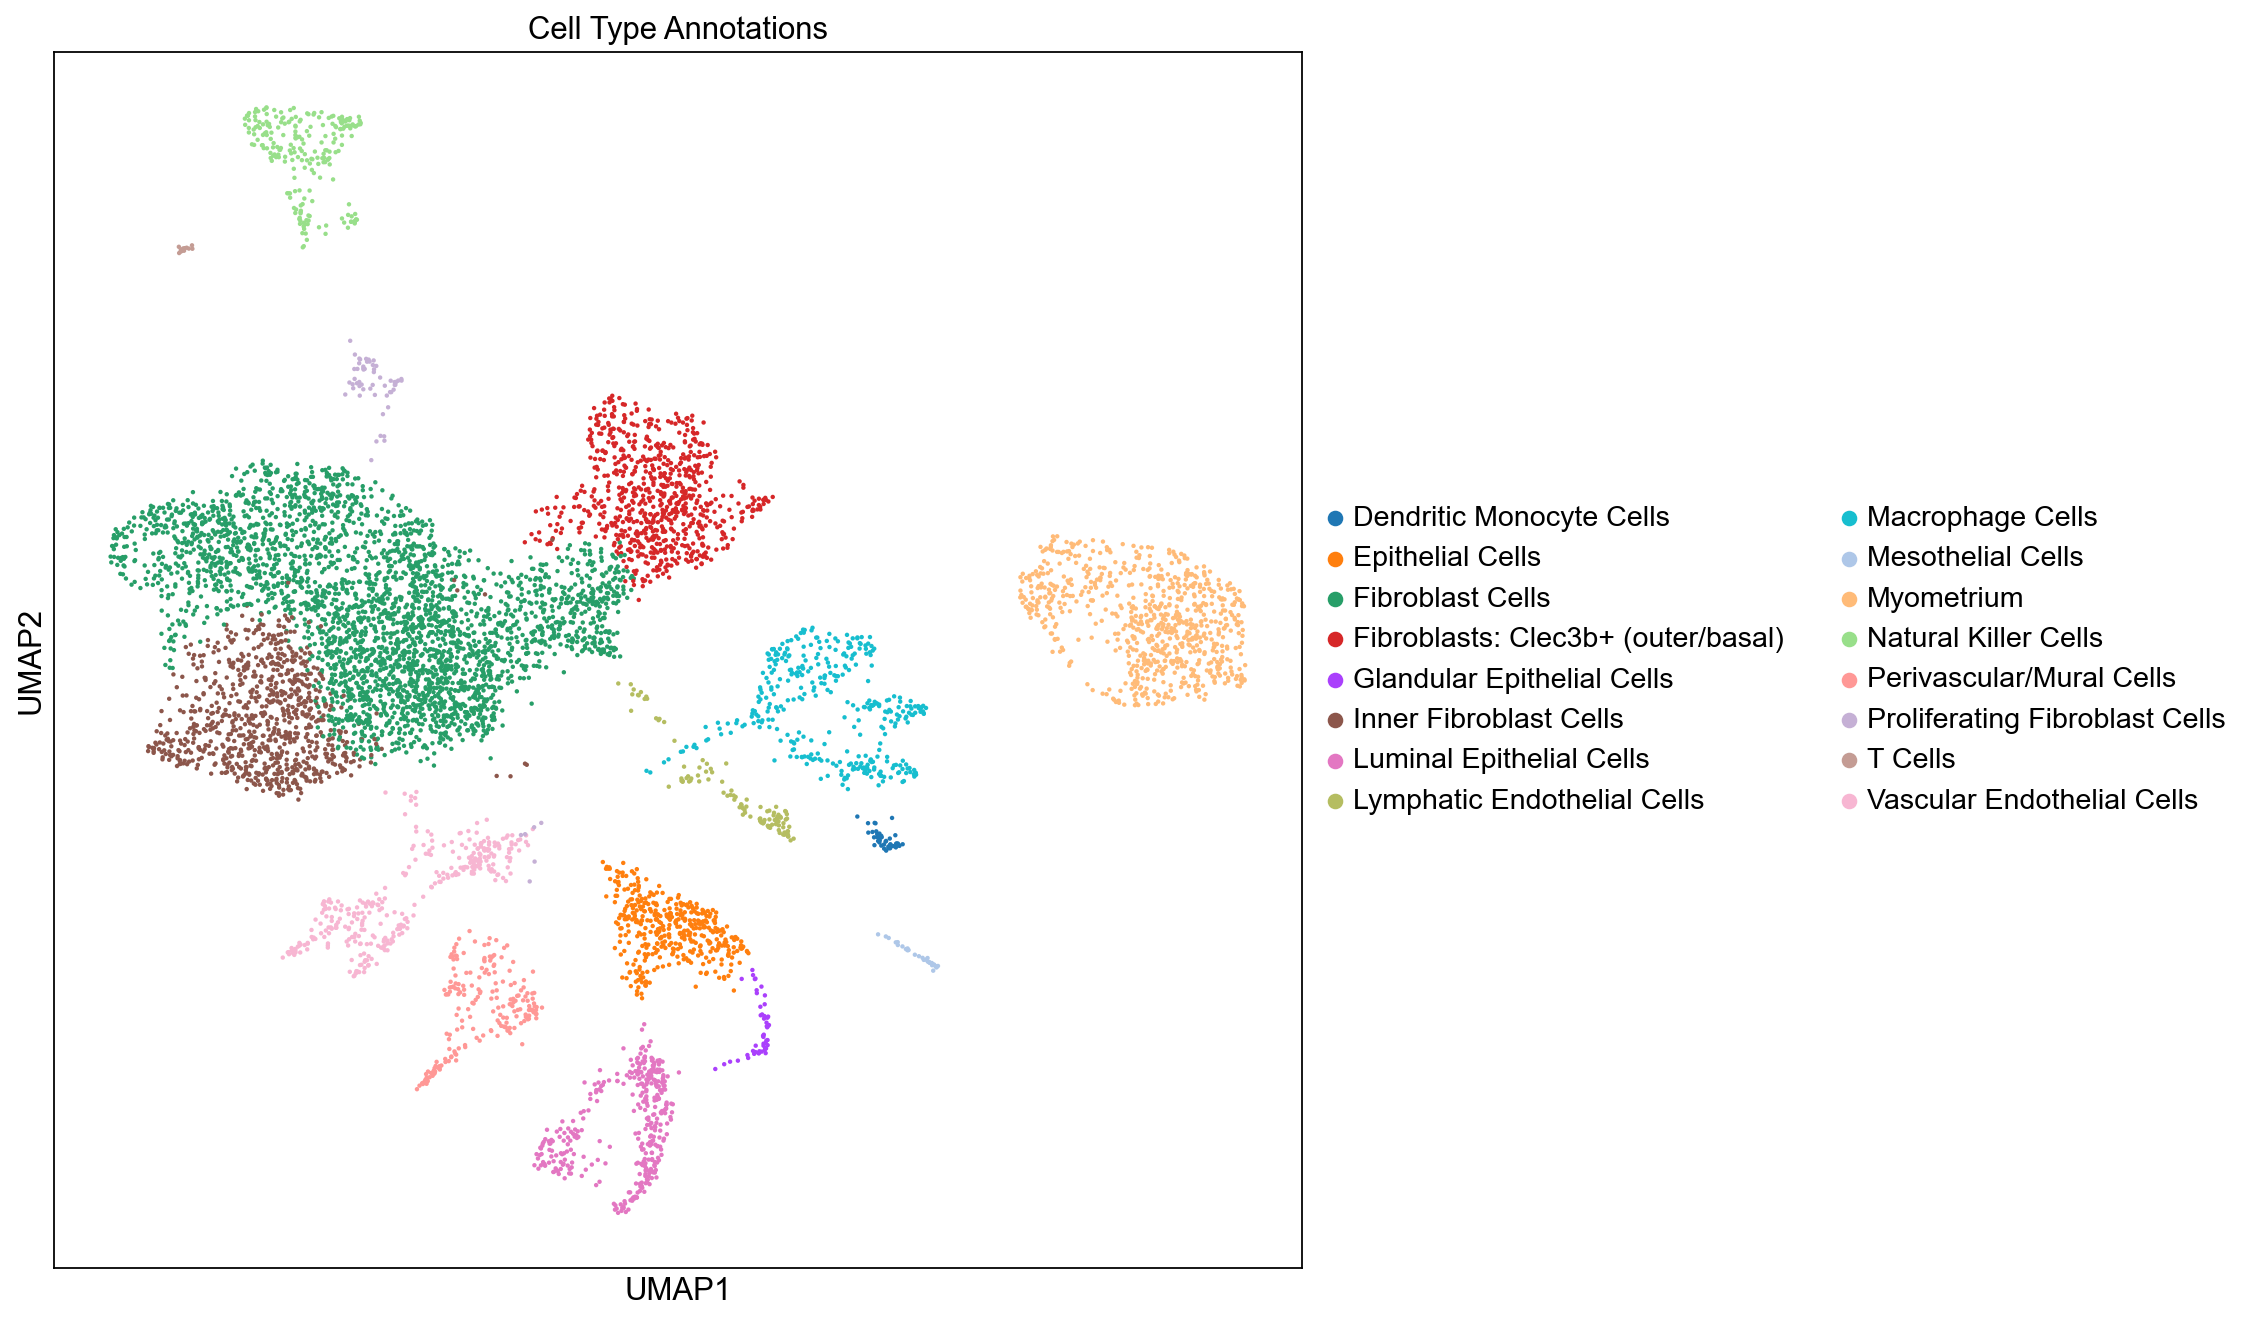

In [93]:
# Visualise cell types

# Filter out cells marked as 'Ignore' or 'Inconclusive'
adata_filtered = adata[~adata.obs['cell_type'].isin(['Ignore', 'Inconclusive'])].copy()

print(f"Plotting {adata_filtered.n_obs} cells (excluded {adata.n_obs - adata_filtered.n_obs} unassigned cells)")

sc.pl.umap(adata_filtered, color='cell_type', title='Cell Type Annotations', show = False)

# save image to output directory
plt.savefig(os.path.join(sc_output_dir, 'umap_cell_type_annotations.png'), dpi=150, bbox_inches='tight')
print(f"UMAP plot saved to {os.path.join(sc_output_dir, 'umap_cell_type_annotations.png')}")
plt.show()

## Quality Checks

Verify cell type annotations with QC metrics.

QC metrics plot saved to z:\thornes\Pavlicev_lab_rotation\FLUXestimator\results\single_cell_annotations\22.01.26\qc_metrics_by_cell_type.png


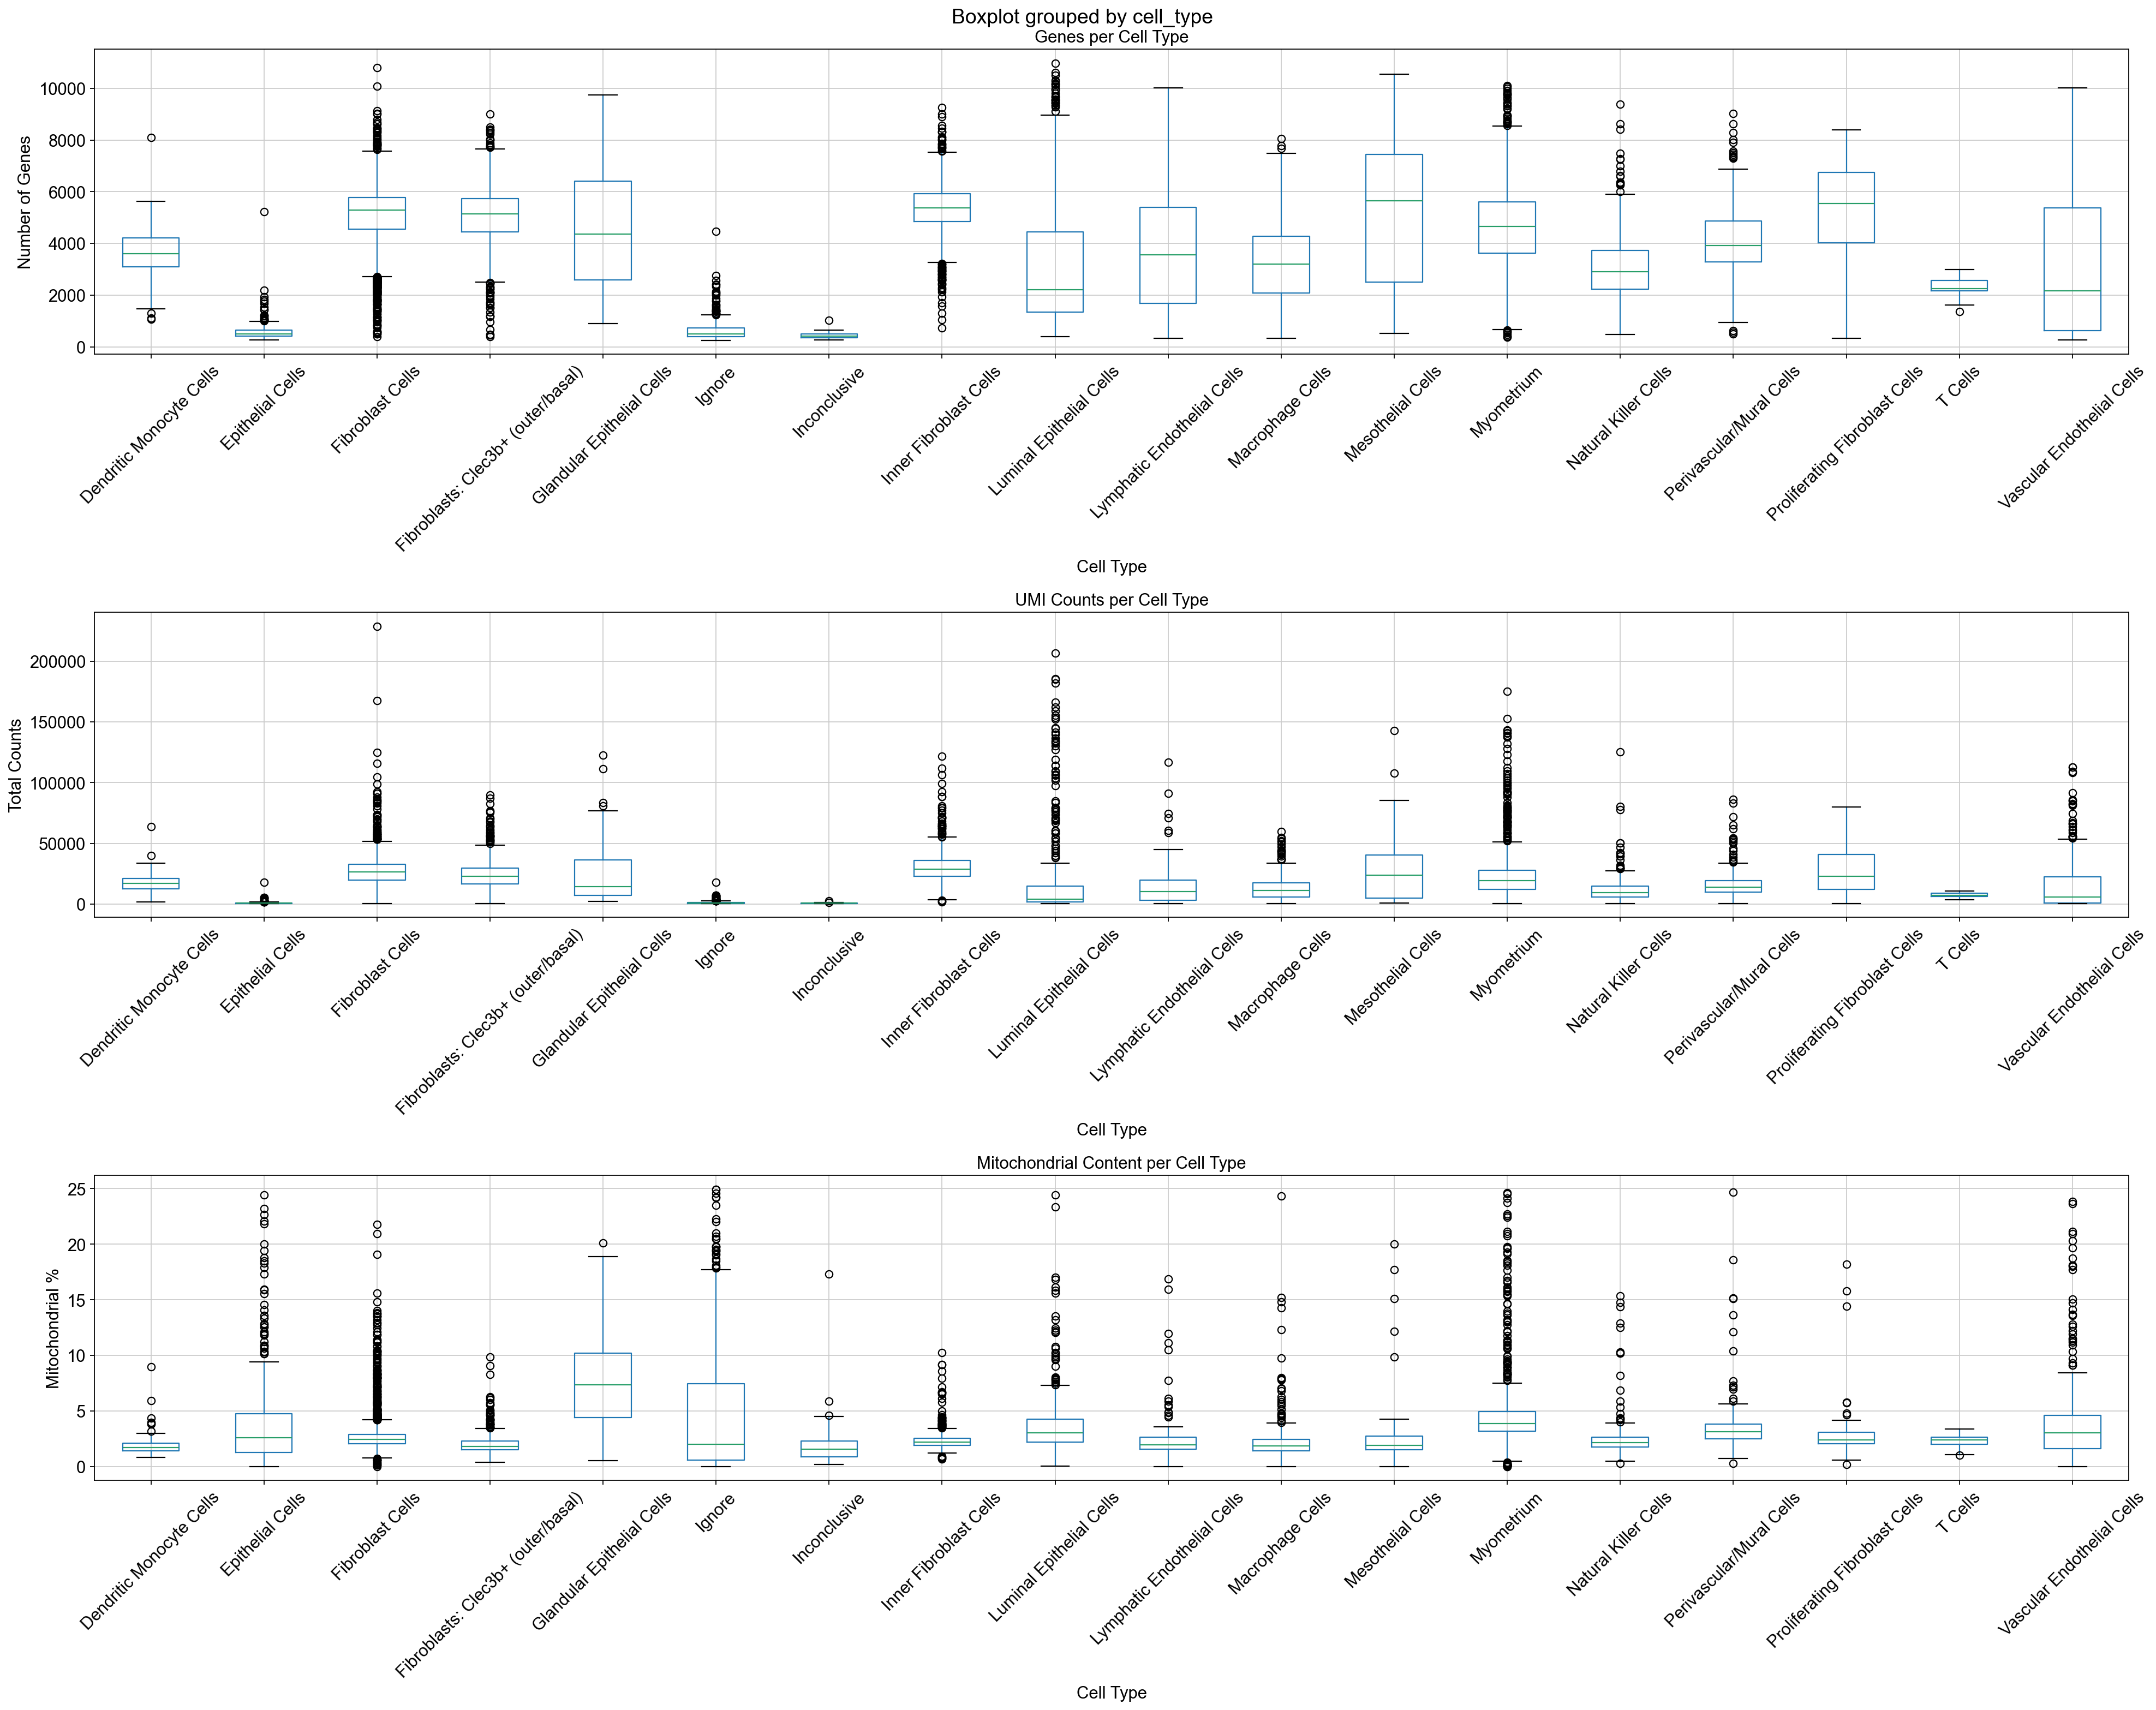

In [94]:
# Compare QC metrics across cell types
fig, axes = plt.subplots(3, 1, figsize=(25, 20))

# Number of genes
adata.obs.boxplot('n_genes_by_counts', by='cell_type', ax=axes[0])
axes[0].set_xlabel('Cell Type')
axes[0].set_ylabel('Number of Genes')
axes[0].set_title('Genes per Cell Type')
axes[0].tick_params(axis='x', rotation=45)

# Total counts
adata.obs.boxplot('total_counts', by='cell_type', ax=axes[1])
axes[1].set_xlabel('Cell Type')
axes[1].set_ylabel('Total Counts')
axes[1].set_title('UMI Counts per Cell Type')
axes[1].tick_params(axis='x', rotation=45)

# Mitochondrial percentage
adata.obs.boxplot('pct_counts_mt', by='cell_type', ax=axes[2])
axes[2].set_xlabel('Cell Type')
axes[2].set_ylabel('Mitochondrial %')
axes[2].set_title('Mitochondrial Content per Cell Type')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
# save image to output directory
plt.savefig(os.path.join(sc_output_dir, 'qc_metrics_by_cell_type.png'), dpi=150, bbox_inches='tight')
print(f"QC metrics plot saved to {os.path.join(sc_output_dir, 'qc_metrics_by_cell_type.png')}")
plt.show()

## Save Annotated Data

In [95]:
# Save annotated data
output_file = f'../data/processed/{suffix}/annotated_data.h5ad'
mkdir_path = os.path.dirname(output_file)
if not os.path.exists(mkdir_path):
    os.makedirs(mkdir_path)
adata.write(output_file, compression='gzip')

print(f"Saved annotated data to {output_file}")
print(f"Dataset: {adata.shape[0]} cells x {adata.shape[1]} genes")
print(f"Cell types: {adata.obs['cell_type'].nunique()}")

Saved annotated data to ../data/processed/22.01.26/annotated_data.h5ad
Dataset: 7964 cells x 23554 genes
Cell types: 18


In [96]:
# Filter genes by those used in scFEA analysis
scfea_genes = pd.read_csv('../data/reference/scFEA_metabolic_genes.csv', header=0).iloc[:, 0].tolist()
print(f"Total scFEA genes in reference: {len(scfea_genes)}")
print(f"First 20 scFEA genes: {scfea_genes[:20]}")

# expr_df_transposed has genes as ROWS (index), cells as COLUMNS
print(f"\nExpression matrix structure:")
print(f"  Shape: {expr_df_transposed.shape}")
print(f"  Index (genes): {len(expr_df_transposed.index)}")
print(f"  Columns (cells): {len(expr_df_transposed.columns)}")

genes_in_data = [g for g in scfea_genes if g in expr_df_transposed.index]
print(f"\nMatching genes found in expression matrix: {len(genes_in_data)}")

# Filter expression matrix to only include scFEA genes (select rows)
expr_df_filtered = expr_df_transposed.loc[genes_in_data, :].copy()
print(f"\nFiltered expression matrix shape: {expr_df_filtered.shape}")

# Save filtered expression matrix
expr_df_filtered.to_csv(f'../data/processed/{suffix}/expr_mtx_scFEA_genes.csv')
print(f"Filtered expression matrix saved to '../data/processed/{suffix}/expr_mtx_scFEA_genes.csv'")

Total scFEA genes in reference: 719
First 20 scFEA genes: ['2410015N17Rik', '2410018C20Rik', '4631427C17Rik', '4732435N03Rik', '4833446K15Rik', 'A030007L17Rik', 'A530050D06Rik', 'Aacs', 'Aadat', 'Aass', 'Abat', 'Abo', 'Acaa1a', 'Acaa1b', 'Acaa2', 'Acaca', 'Acacb', 'Acad8', 'Acadl', 'Acadm']

Expression matrix structure:
  Shape: (23554, 7964)
  Index (genes): 23554
  Columns (cells): 7964

Matching genes found in expression matrix: 612

Filtered expression matrix shape: (612, 7964)
Filtered expression matrix saved to '../data/processed/22.01.26/expr_mtx_scFEA_genes.csv'


## Next Steps

Proceed to notebook `03_flux_estimation.ipynb` for metabolic flux analysis.